<h1 style="color:#1E90FF;">📈 Retail Sales Forecasting with Time Series</h1>
<h3>📦 Powered by ARIMA/SARIMA | 🎯 MAPE Evaluation | 📊 Monthly Trend Insights</h3>


In [1]:
# Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 2: Load Dataset
df = pd.read_csv('retail_sales_dataset.csv')  # Make sure the file is in the same directory
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
521,522,2023-01-01,CUST522,Male,46,Beauty,3,500,1500
179,180,2023-01-01,CUST180,Male,41,Clothing,3,300,900
558,559,2023-01-01,CUST559,Female,40,Clothing,4,300,1200
302,303,2023-01-02,CUST303,Male,19,Electronics,3,30,90
978,979,2023-01-02,CUST979,Female,19,Beauty,1,25,25


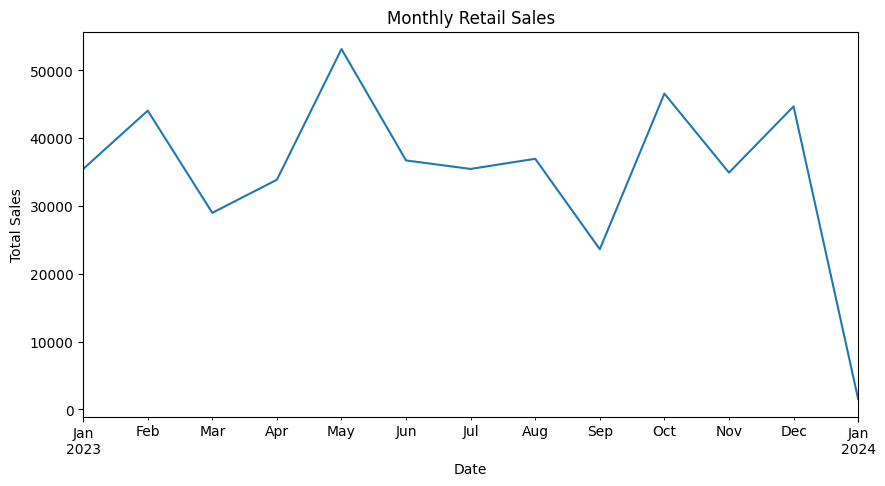

Date
2023-01-31    35450
2023-02-28    44060
2023-03-31    28990
2023-04-30    33870
2023-05-31    53150
Freq: ME, Name: Total Amount, dtype: int64

In [3]:
# Step 3: Aggregate to Monthly Sales
monthly_sales = df.groupby(pd.Grouper(key='Date', freq='M'))['Total Amount'].sum()
monthly_sales.plot(title='Monthly Retail Sales', figsize=(10,5))
plt.ylabel('Total Sales')
plt.show()
monthly_sales.head()

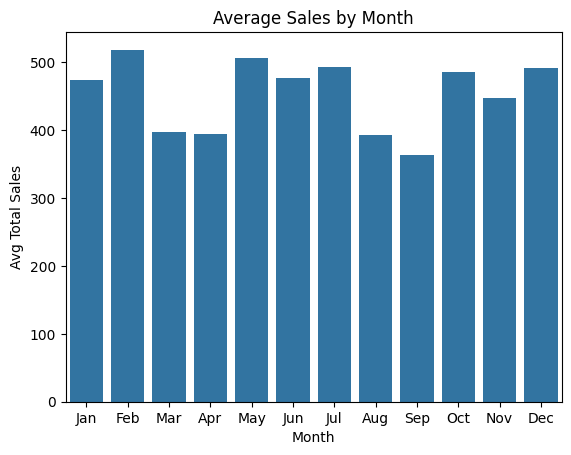

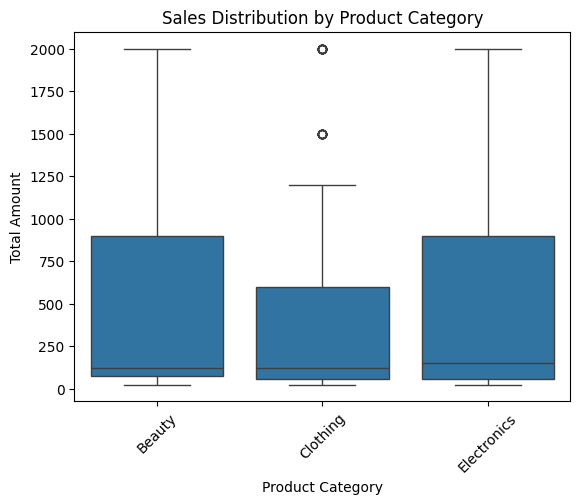

In [4]:
#Step 3.1: Exploratory Data Analysis
df['Month'] = df['Date'].dt.strftime('%b')

# Monthly Sales Pattern
sns.barplot(x='Month', y='Total Amount', data=df, estimator=np.mean, ci=None)
plt.title('Average Sales by Month')
plt.ylabel('Avg Total Sales')
plt.show()

# Sales by Product Category
sns.boxplot(x='Product Category', y='Total Amount', data=df)
plt.title('Sales Distribution by Product Category')
plt.xticks(rotation=45)
plt.show()

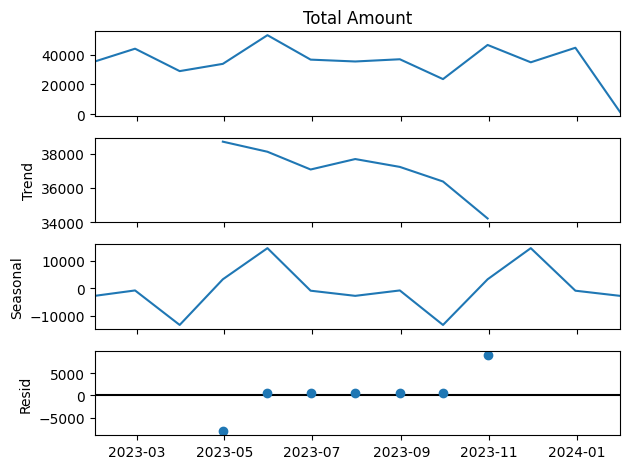

In [5]:
# Step 4: Decomposition (if at least 13 data points are available)
if len(monthly_sales) >= 13:
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose = seasonal_decompose(monthly_sales, model='additive', period=6)  # Using 6-month seasonality
    decompose.plot()
    plt.show()
else:
    print(f"Not enough data to decompose. Required: 13, Available: {len(monthly_sales)}")


In [6]:
# Step 5: Check Stationarity with ADF Test
result = adfuller(monthly_sales)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Series is non-stationary, applying differencing')
    monthly_sales = monthly_sales.diff().dropna()
    print('Differencing done')

ADF Statistic: -3.6702088100655903
p-value: 0.0045522517976560595


In [7]:
# Step 6: Fit SARIMA Model
model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Total Amount   No. Observations:                   13
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 26 Jun 2025   AIC                             10.000
Time:                                    23:08:32   BIC                               -inf
Sample:                                01-31-2023   HQIC                               nan
                                     - 01-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0        nan        nan        nan         nan         nan
ma.L1               0        nan   

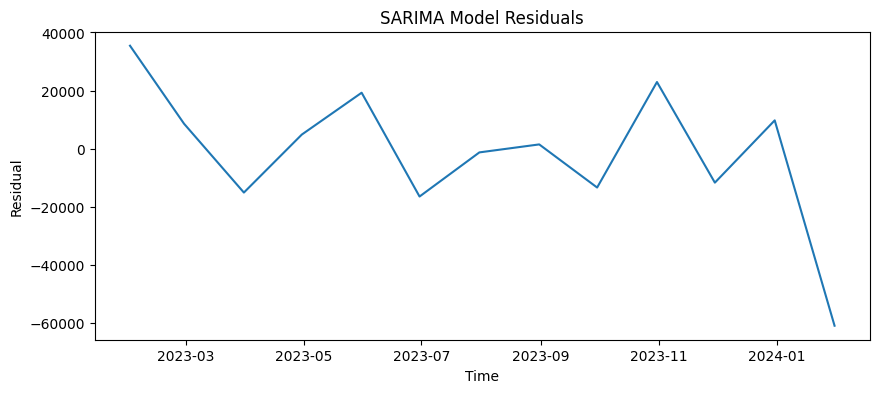

In [8]:
# Step 6.1: Model Diagnostics
# Residual diagnostics
residuals = results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("SARIMA Model Residuals")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

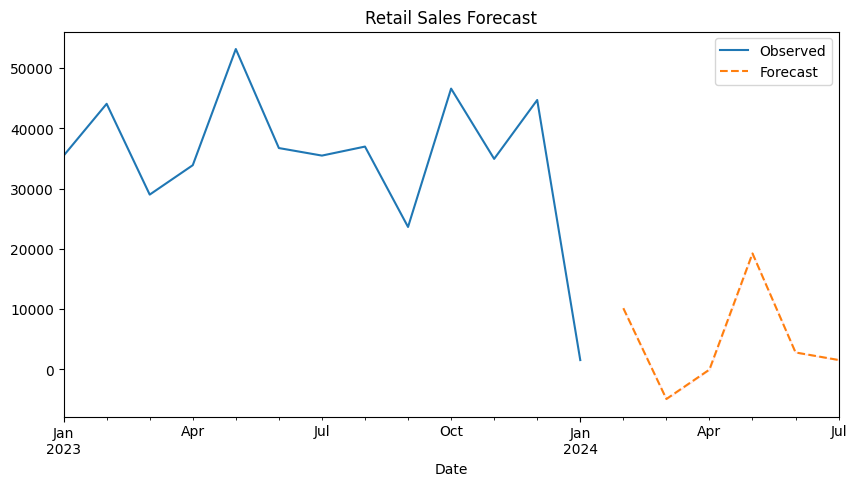

In [9]:
# Step 7: Forecast Next 6 Months
forecast = results.get_forecast(steps=6)
forecast_ci = forecast.conf_int()
forecast_mean = forecast.predicted_mean
plt.figure(figsize=(10,5))
monthly_sales.plot(label='Observed')
forecast_mean.plot(label='Forecast', style='--')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Retail Sales Forecast')
plt.savefig("output/forecast_plot.png") 
plt.show()

In [10]:
# Step 8: Evaluate with MAPE (using last 6 actuals if available)
actual = monthly_sales[-6:]
pred = forecast_mean[:len(actual)]
mape = mean_absolute_percentage_error(actual, pred)
print(f'MAPE: {mape:.2%}')

MAPE: 72.20%
